<a href="https://colab.research.google.com/github/naenumtou/ifrs9/blob/main/PD/univariateAnalysis1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Set auto reload
%reload_ext autoreload
%autoreload 2

In [2]:
# Upgrade scikit-learn version -> 1.0
!pip install -U scikit-learn

In [3]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from scipy.special import logit
from sklearn.feature_selection import SelectKBest, f_regression

%config InlineBackend.figure_format = 'retina'

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
# Import dependence variable
odr = pd.read_csv('https://raw.githubusercontent.com/naenumtou/ifrs9/main/PD/datasets/monthlyODR.csv')
odr = odr.query("Segment == 'CU'") #Select only one segment
odr = odr.drop(['Monthkey'], axis = 1) #Drop 'Monthkey' will be added from MEV Data
odr = odr.eval("ODR = Bad / N") #ODR Calculation (12-Motnhs bad rate)

# Import macroeconomics data
mev = pd.read_csv('https://raw.githubusercontent.com/naenumtou/ifrs9/main/PD/datasets/macroTransformed.csv')

# Assign date to dependence variable
odr['Date'] = mev['Date']
odr.head(5)

,Segment,N,Bad,ODR,Date
0,CU,21556,815.0,0.037808,2014-01-01
1,CU,21794,885.0,0.040608,2014-02-01
2,CU,21911,920.0,0.041988,2014-03-01
3,CU,22128,960.0,0.043384,2014-04-01
4,CU,22115,989.0,0.044721,2014-05-01


# Transformations of proportions and percentages
For a binomial distribution, variance is a function of the mean, reaching a maximum value at a proportion of 0.5, and declining to zero at proportions of zero and one. Variance-stabilizing transformations are used to correct this problem in binomial data, and two of the most common variance-stabilizing transformations are the logit and arcsine transformations. These transformations are also used for percentage data that may not follow a binomial distribution.

## Logit transformation
The logit transformation is the log of the odds ratio, that is, the log of the proportion divided by one minus the proportion. The base of the logarithm isn’t critical, and e is a common base.

Logit ODR = $log(\frac{ODR}{1 - ODR})$

In [5]:
# Dependence variable transformation
# Logit transformation
odr['logitODR'] = logit(odr['ODR'])

## Arcsine transformation
The arcsine transformation (also called the arcsine square root transformation, or the angular transformation) is calculated as two times the arcsine of the square root of the proportion. In some cases, the result is not multiplied by two (Sokal and Rohlf 1995).

Arcsine ODR = $arcsin(\sqrt{ODR})$

In [6]:
# Arcsine transformation
odr['arcsineODR'] = np.arcsin(np.sqrt(odr['ODR']))

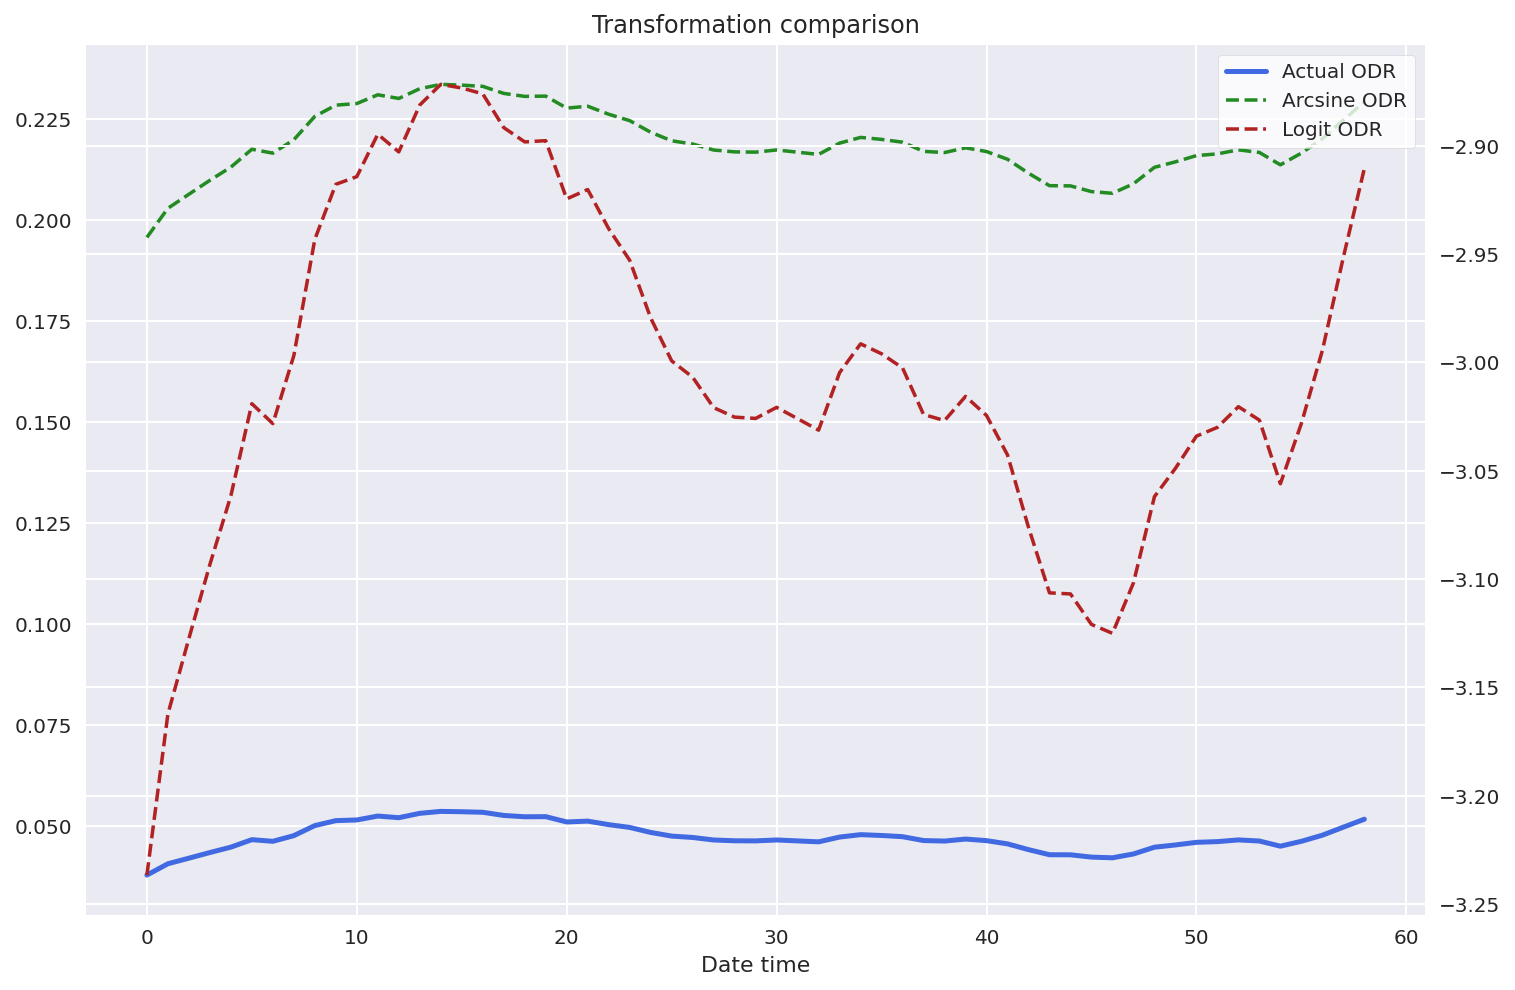

In [7]:
# Results comparison
plt.figure(figsize = (12, 8))
with plt.style.context('seaborn'):
  plt.title('Transformation comparison')
  plt.xlabel('Date time')
  labsODR = plt.plot(odr['ODR'], c = 'royalblue', linewidth = 2.5, label = 'Actual ODR')
  labsArcsine = plt.plot(odr['arcsineODR'], c = 'forestgreen', linestyle = '--', label = 'Arcsine ODR')
  # Twin X Plot
  plt.twinx()
  labsLogit = plt.plot(odr['logitODR'], c = 'firebrick', linestyle = '--', label = 'Logit ODR')
  # Combine legend
  labs = labsODR + labsArcsine + labsLogit
  labels = [l.get_label() for l in labs]
  plt.legend(labs, labels, frameon = True, facecolor = 'white', loc = 1)
plt.show()

In [8]:
# Mapping with logit ODR
df = pd.merge(odr[['Date', 'logitODR']],
              mev,
              how = 'left',
              left_on = ['Date'],
              right_on = ['Date'])
df = df.set_index('Date')
df.head(5)

,logitODR,FDI,HD,GDP,RSI,CPI,Wage,UR,OP,Im,Ex,PCI,CCI,API,PII,MPI,PIR,FDI_LN,HD_LN,GDP_LN,RSI_LN,CPI_LN,Wage_LN,UR_LN,OP_LN,Im_LN,Ex_LN,PCI_LN,CCI_LN,API_LN,PII_LN,MPI_LN,PIR_LN,FDI_M3,FDI_M6,FDI_M9,FDI_M12,HD_M3,HD_M6,HD_M9,...,CCI_C_lg9,CCI_C_lg10,CCI_C_lg11,CCI_C_lg12,API_C_lg1,API_C_lg2,API_C_lg3,API_C_lg4,API_C_lg5,API_C_lg6,API_C_lg7,API_C_lg8,API_C_lg9,API_C_lg10,API_C_lg11,API_C_lg12,PII_C_lg1,PII_C_lg2,PII_C_lg3,PII_C_lg4,PII_C_lg5,PII_C_lg6,PII_C_lg7,PII_C_lg8,PII_C_lg9,PII_C_lg10,PII_C_lg11,PII_C_lg12,MPI_C_lg1,MPI_C_lg2,MPI_C_lg3,MPI_C_lg4,MPI_C_lg5,MPI_C_lg6,MPI_C_lg7,MPI_C_lg8,MPI_C_lg9,MPI_C_lg10,MPI_C_lg11,MPI_C_lg12
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-01-01,-3.236680,189417.136534,8.560335e+06,2.381830e+06,212.76,100.15,12911.24,0.94,107.42,637677.49,587085.59,111.37,29.5,150.804689,121.98,100.073269,2.25,12.151707,15.962650,14.683380,5.360165,4.606669,9.465854,-0.061875,4.676746,13.365588,13.282926,4.712858,3.384390,5.015986,4.803857,4.605903,0.810930,188385.514044,189952.931678,189814.358032,190734.781579,8.509564e+06,8.388654e+06,8.280323e+06,...,0.551944,0.499457,0.227784,0.313181,0.033815,-0.006416,-0.012409,0.010903,0.018121,-0.011507,0.006890,-0.005963,-0.042972,-0.053358,-0.052771,-0.041031,-0.021557,-0.025671,-0.026563,-0.006897,-0.015199,-0.022686,-0.043988,-0.038724,0.004171,-0.000974,0.029274,0.151198,-0.093903,-0.102690,-0.061016,-0.028748,-0.013185,-0.008389,0.025905,0.046398,0.089870,0.143477,0.119307,0.239164
2014-02-01,-3.162347,193355.095090,8.576515e+06,2.397283e+06,206.74,100.39,12809.44,0.86,108.81,488289.38,598571.15,102.51,26.7,145.387932,118.41,100.594662,2.25,12.172284,15.964538,14.689847,5.331462,4.609063,9.457938,-0.150823,4.689603,13.098664,13.302301,4.629960,3.284664,4.979406,4.774153,4.611099,0.810930,190038.653875,190305.154152,190079.124929,190886.367688,8.552638e+06,8.452922e+06,8.345568e+06,...,0.380833,0.551944,0.499457,0.227784,0.000948,0.033815,-0.006416,-0.012409,0.010903,0.018121,-0.011507,0.006890,-0.005963,-0.042972,-0.053358,-0.052771,-0.016424,-0.021557,-0.025671,-0.026563,-0.006897,-0.015199,-0.022686,-0.043988,-0.038724,0.004171,-0.000974,0.029274,-0.116277,-0.093903,-0.102690,-0.061016,-0.028748,-0.013185,-0.008389,0.025905,0.046398,0.089870,0.143477,0.119307
2014-03-01,-3.127475,196757.890000,8.589811e+06,2.386443e+06,231.55,100.60,12633.14,0.88,107.40,553252.08,641085.67,118.68,27.5,146.000067,131.07,109.942282,2.00,12.189729,15.966087,14.685315,5.444796,4.611152,9.444079,-0.127833,4.676560,13.223569,13.370918,4.776431,3.314186,4.983607,4.875732,4.699956,0.693147,193176.707208,191032.969152,190993.494929,191044.206021,8.575554e+06,8.507640e+06,8.403359e+06,...,0.348307,0.380833,0.551944,0.499457,-0.027885,0.000948,0.033815,-0.006416,-0.012409,0.010903,0.018121,-0.011507,0.006890,-0.005963,-0.042972,-0.053358,-0.006985,-0.016424,-0.021557,-0.025671,-0.026563,-0.006897,-0.015199,-0.022686,-0.043988,-0.038724,0.004171,-0.000974,-0.058933,-0.116277,-0.093903,-0.102690,-0.061016,-0.028748,-0.013185,-0.008389,0.025905,0.046398,0.089870,0.143477
2014-04-01,-3.093313,198952.610990,8.618880e+06,2.346222e+06,205.79,101.10,13219.29,0.90,107.79,559413.50,556218.79,116.48,29.8,142.590361,119.25,89.339924,2.00,12.200822,15.969466,14.668317,5.326856,4.616110,9.489432,-0.105361,4.680185,13.234644,13.228917,4.757720,3.394508,4.959976,4.781222,4.492448,0.693147,196355.198693,192370.356369,192087.020683,191449.568197,8.595069e+06,8.552316e+06,8.457459e+06,...,0.240180,0.348307,0.380833,0.551944,-0.017446,-0.027885,0.000948,0.033815,-0.006416,-0.012409,0.010903,0.018121,-0.011507,0.006890,-0.005963,-0.042972,-0.018145,-0.006985,-0.016424,-0.021557,-0.025671,-0.026563,-0.006897,-0.015199,-0.022686,-0.043988,-0.038724,0.004171,-0.088659,-0.058933,-0.116277,-0.093903,-0.102690,-0.061016,-0.028748,-0.013185,-0.008389,0.025905,0.046398,0.089870
2014-05-01,-3.061565,200103.269226,8.659787e+06,2.292120e+06,214.25,101.51,13264.39,0.94,1

In [9]:
# Correlation analysis
dfCorr = df.corr()

# Select first 50 highest correlation
selected = abs(dfCorr['logitODR']).sort_values(ascending = False)[:50].index #Without 'logitODR'
dfCorr = dfCorr[selected] #Select columns
dfCorr = dfCorr.reset_index()
dfCorr = dfCorr[dfCorr['index'].isin(selected)] #Select index
dfCorr = dfCorr.sort_values(by = ['logitODR'], ascending = False, key = abs).set_index('index') #Sort values to plot 

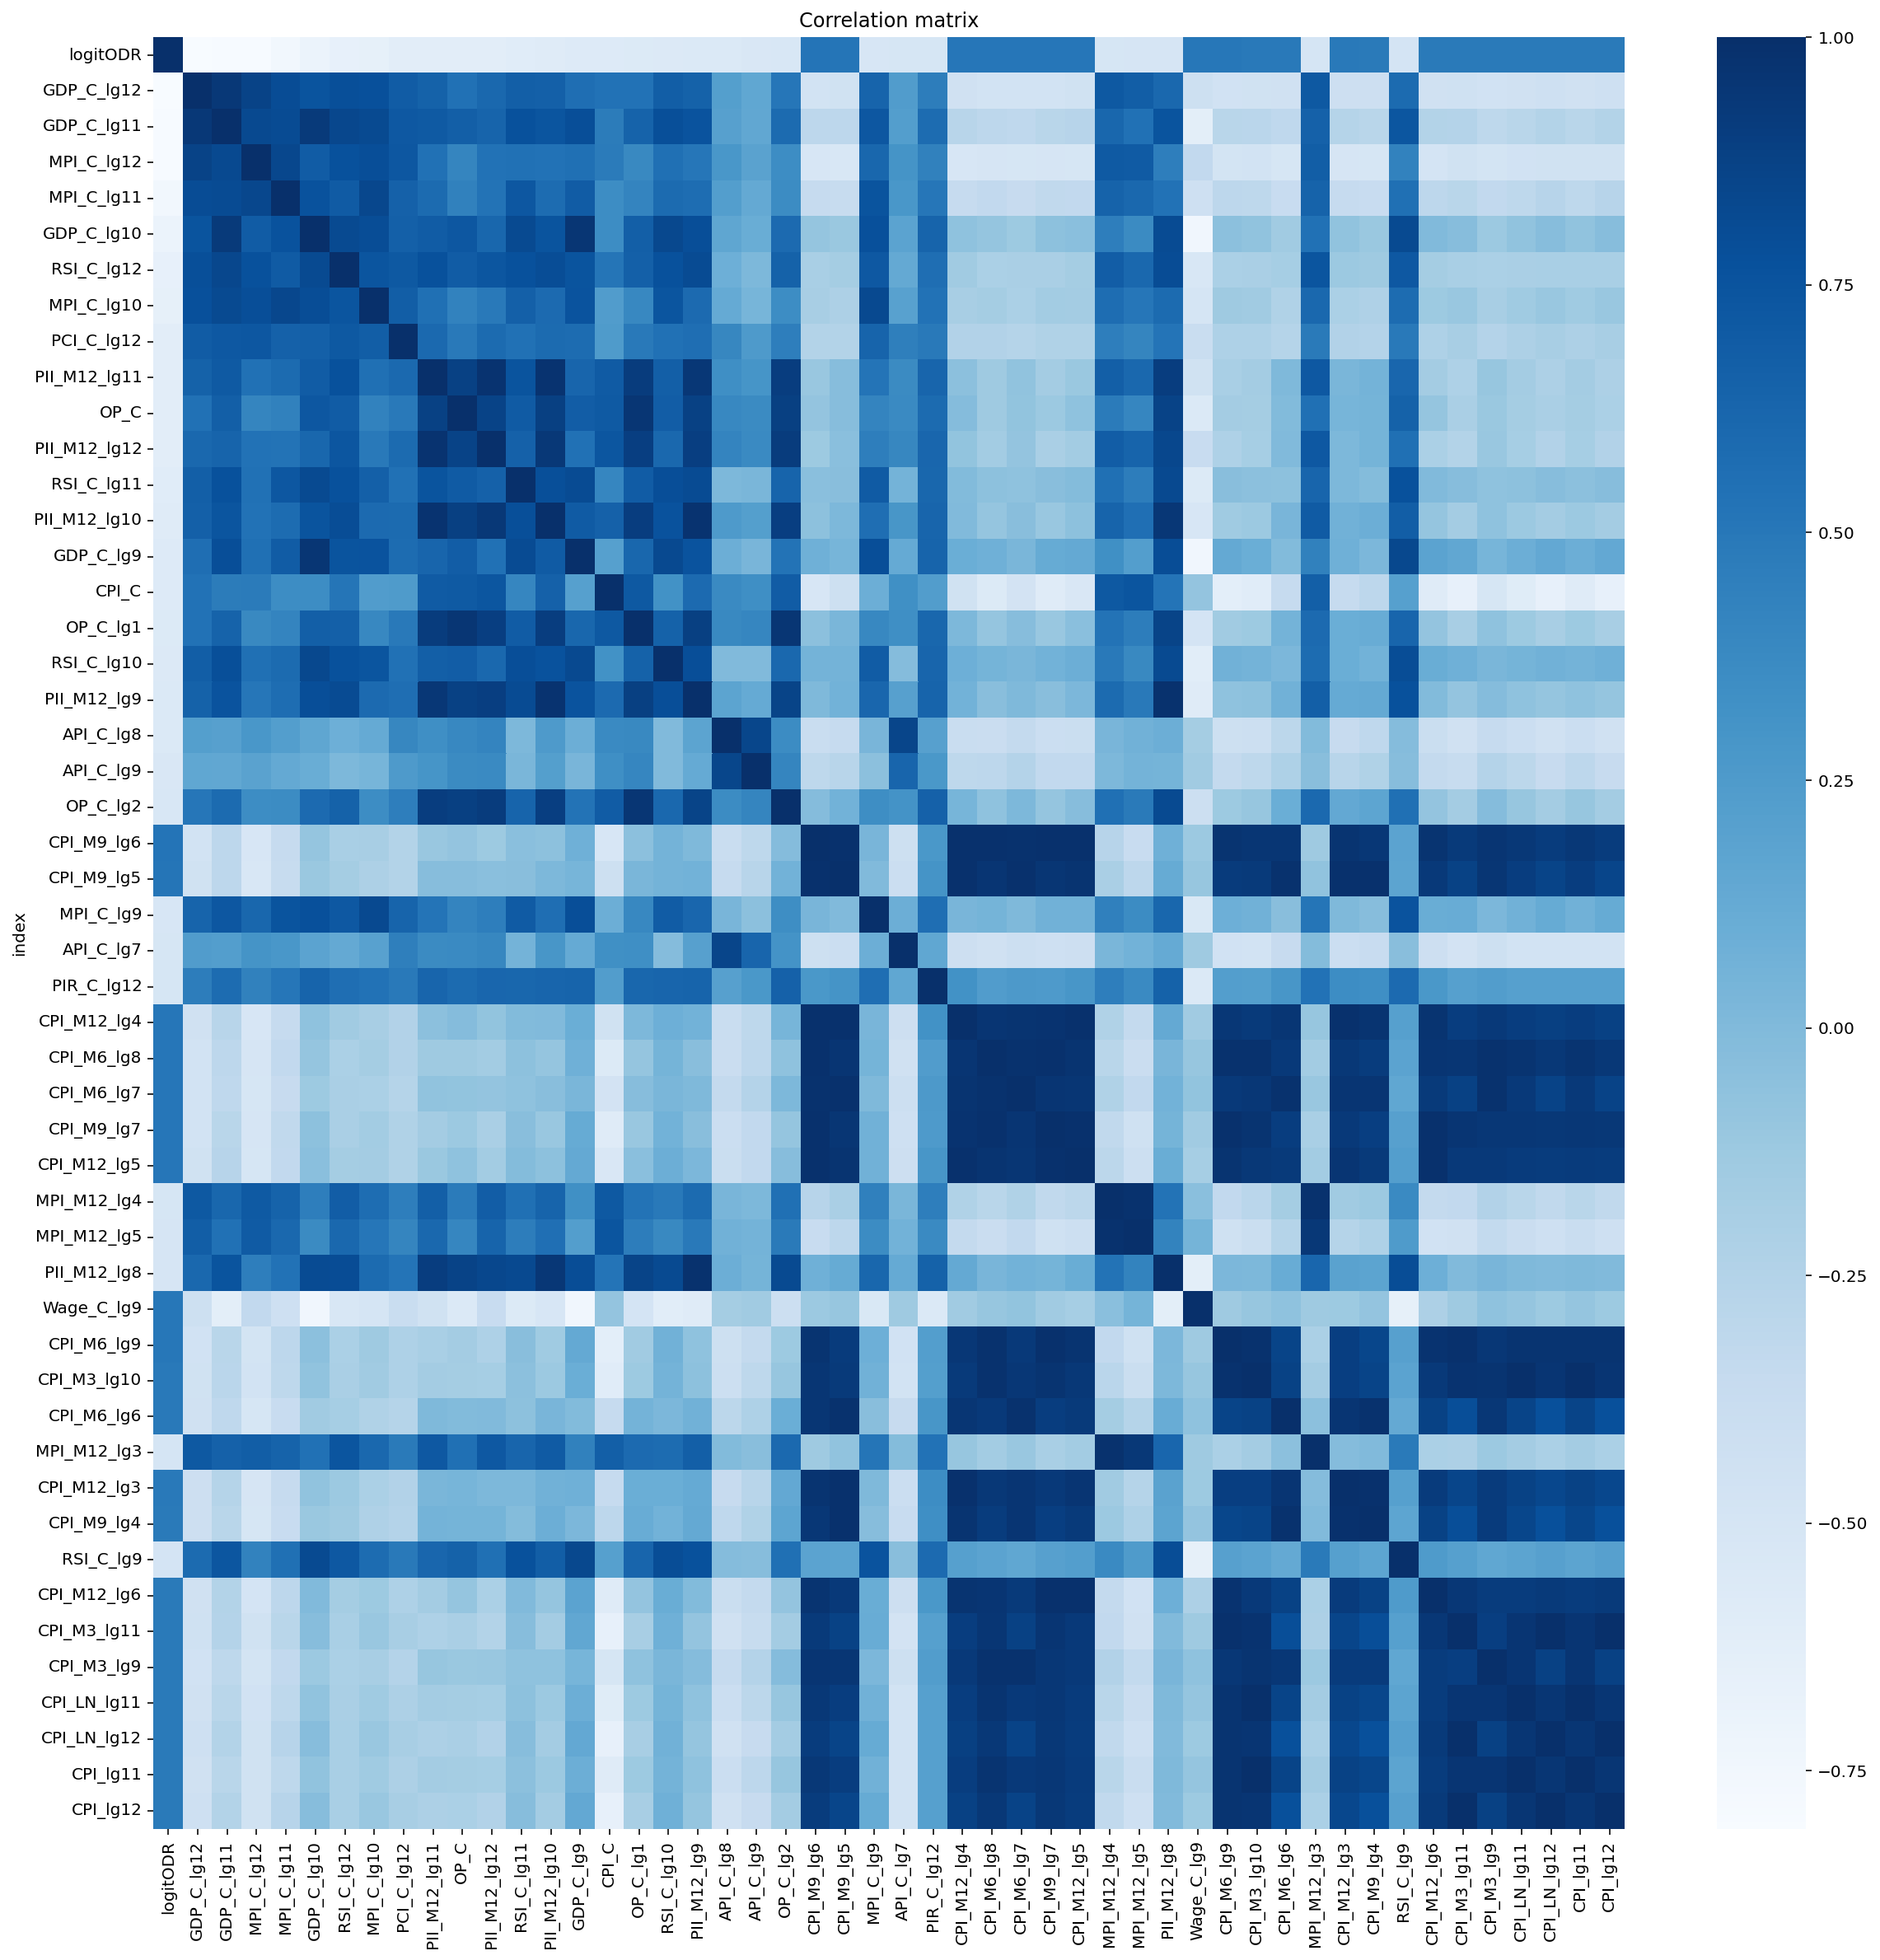

In [10]:
# Plot correlation matrix
plt.figure(figsize = (20, 20))
plt.title('Correlation matrix')
sns.heatmap(dfCorr, xticklabels = True, yticklabels = True, cmap = plt.cm.Blues) #Show all labels
plt.show()

In [11]:
# Features selection
# Import sign of variables
sign = pd.read_csv('https://raw.githubusercontent.com/naenumtou/ifrs9/main/PD/datasets/macroSignTransformed.csv')

# Correlation table
corrResult = dfCorr[['logitODR']].reset_index() #Correlation with logit ODR
corrResult = corrResult.rename(columns = {'index': 'Variable', 'logitODR': 'Correlation'})

# Mapping sign of variables
corrResult = pd.merge(corrResult,
                      sign[['Variable', 'Sign']],
                      how = 'left',
                      left_on = ['Variable'],
                      right_on = ['Variable'])
corrResult = corrResult.dropna() #Drop logit ODR row

In [12]:
# Selection based on 50% Correlation in absolute term and correct sign
threshold = 0.5
condition = (abs(corrResult['Correlation']) >= threshold) & (corrResult['Correlation'] / corrResult['Sign'] >= 0)
corrResult['Select'] = np.where(condition, 1, 0)

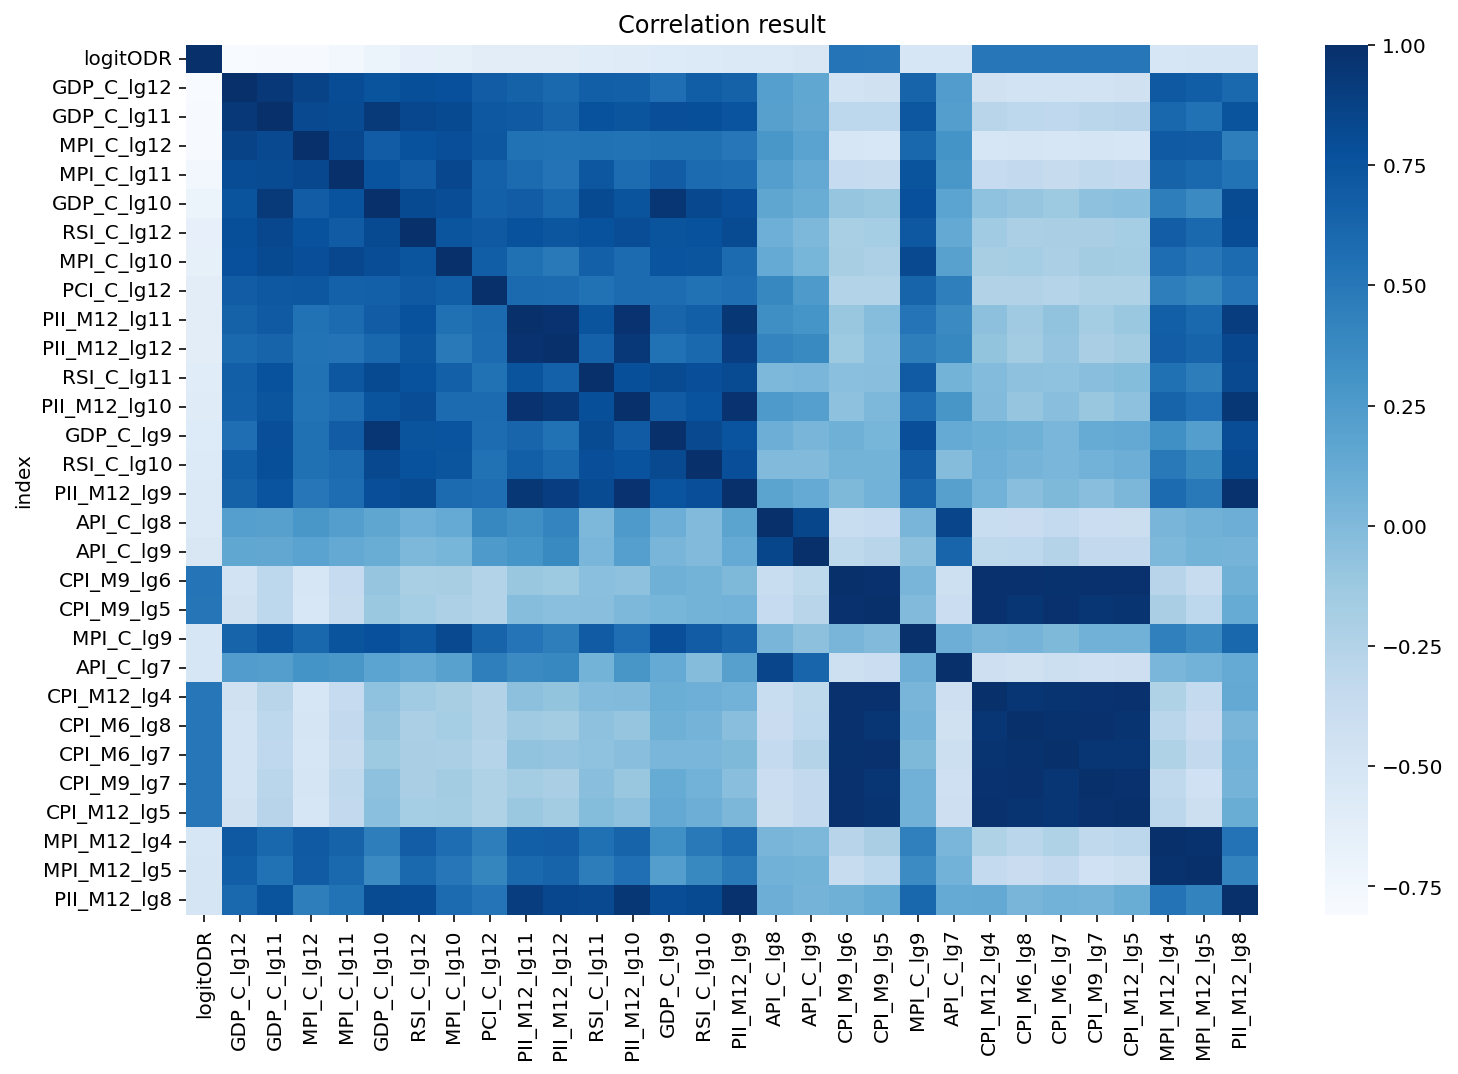

In [13]:
# Plot results
corrList = list(corrResult.query("Select == 1")['Variable']) #Only selected
corrList.insert(0, 'logitODR') #Insert at the first positon

# Select DataFrame
corrPlot = dfCorr.query('index in @corrList')
corrPlot = corrPlot[corrList]

# Plot
plt.figure(figsize = (12, 8))
plt.title('Correlation result')
sns.heatmap(corrPlot, xticklabels = True, yticklabels = True, cmap = plt.cm.Blues)
plt.show()

In [14]:
# Regression selection
# Target and features seperation
X = df.drop(['logitODR'], axis = 1)
y = df['logitODR']

In [15]:
# f_regression selection
selector = SelectKBest(f_regression, k = 'all')
selector.fit(X, y)

# Format to DataFrame
fregResult = pd.DataFrame(selector.feature_names_in_, columns = ['Variable']) #For sklearn version 1.0+
fregResult['FScore'], fregResult['PValue'] = selector.scores_, selector.pvalues_
fregResult = fregResult.sort_values(by = ['FScore'], ascending = False)[:20] #Top first 20

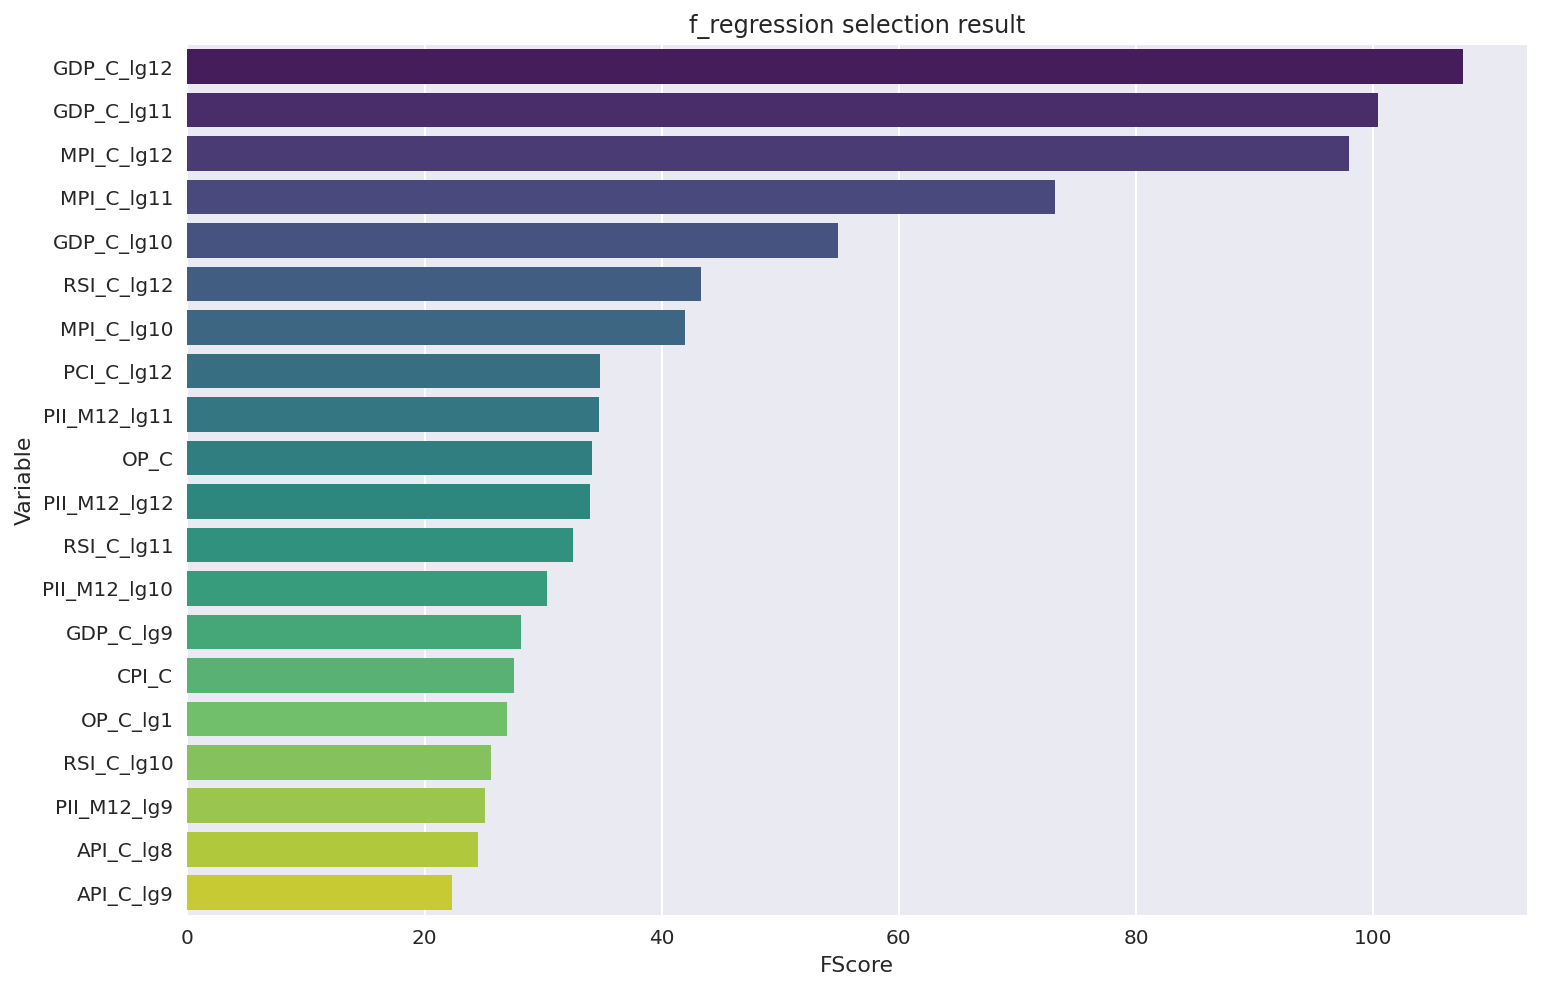

In [16]:
# Plot results
with plt.style.context('seaborn'):
  plt.figure(figsize = (12, 8))
  plt.title('f_regression selection result')
  sns.barplot(x = 'FScore', y = 'Variable', data = fregResult,
              palette = 'viridis')
plt.show()

In [17]:
# Simple regression selection
betaResult = []

for variable in X.columns:
  XTrain = sm.add_constant(X[variable], has_constant = 'add')
  model = sm.OLS(y, XTrain).fit()
  betaResult.append([variable, model.params[-1], model.pvalues[-1]]) #Get only beta 1 coefficient

# Format to DataFrame
betaResult = pd.DataFrame(betaResult, columns = ['Variable', 'Coefficient', 'pValue'])

# Mapping sign of variables
betaResult = pd.merge(betaResult,
                      sign[['Variable', 'Sign']],
                      how = 'left',
                      left_on = ['Variable'],
                      right_on = ['Variable'])

In [18]:
# Selection based on correct sign of beta
condition = betaResult['Coefficient'] / betaResult['Sign'] >= 0
betaResult['Select'] = np.where(condition, 1, 0)

# Only passed and significant pvalues
betaResult = betaResult.query("Select == 1").sort_values(by = ['pValue'], ascending = True)[:20] #Top first 20

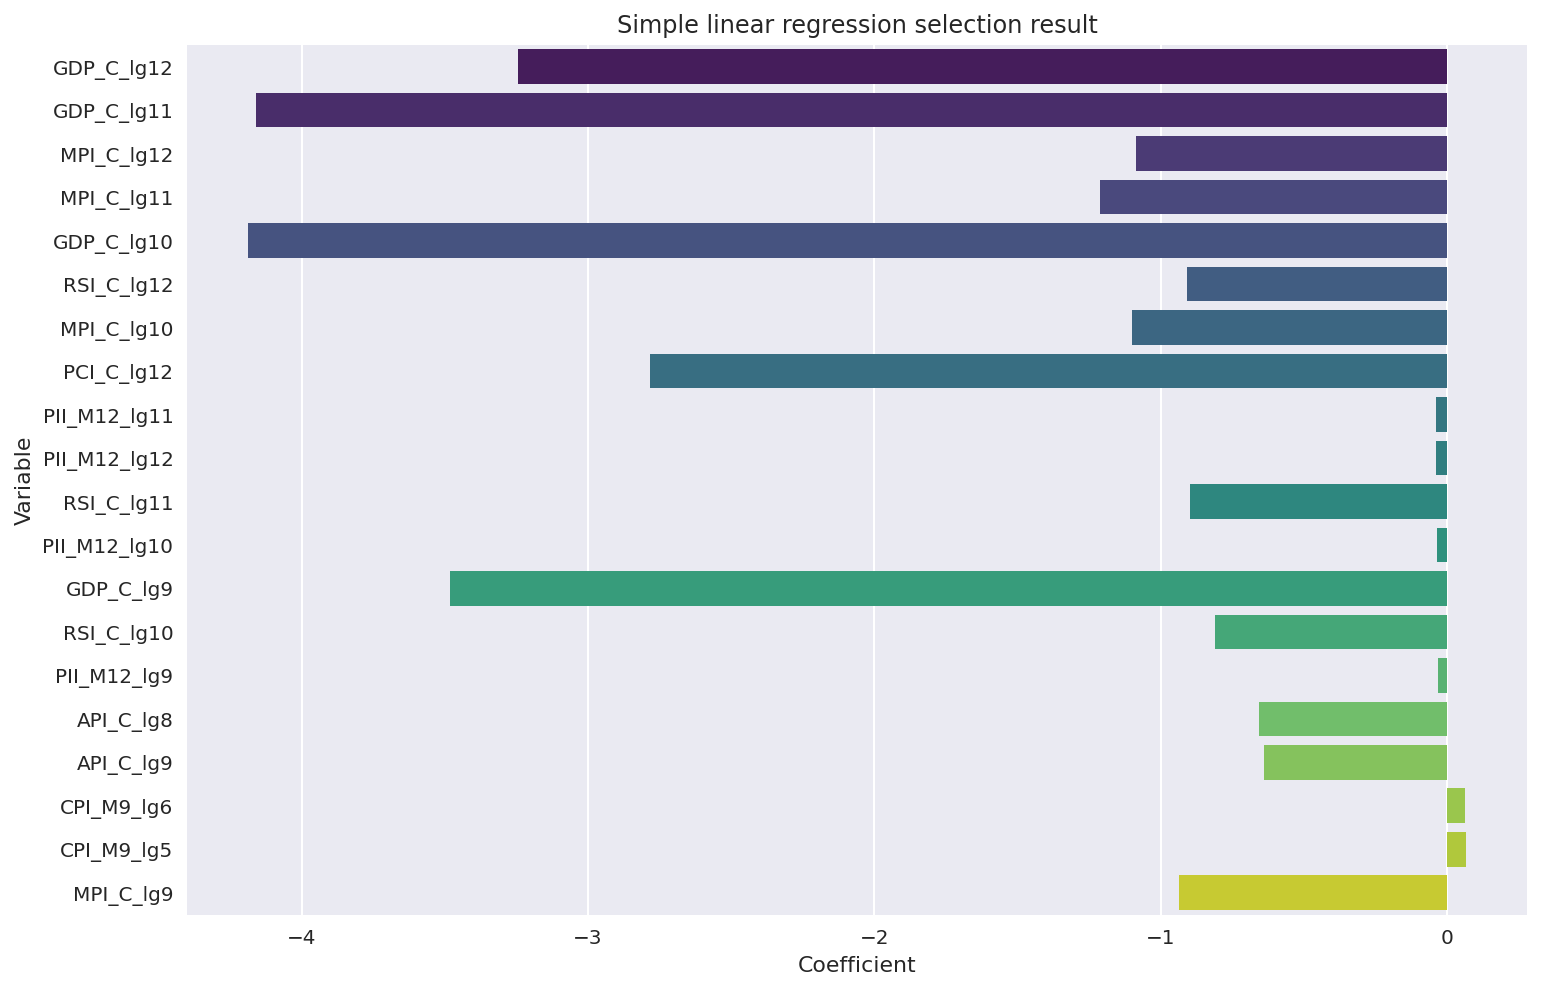

In [19]:
# Plot results
with plt.style.context('seaborn'):
  plt.figure(figsize = (12, 8))
  plt.title('Simple linear regression selection result')
  sns.barplot(x = 'Coefficient', y = 'Variable', data = betaResult,
              palette = 'viridis')
plt.show()